In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from sklearn.linear_model import LinearRegression

In [2]:
!ls tbd-back-main

data		    Dockerfile	README.md	  server.py
docker-compose.yml  LICENSE	requirements.txt


In [3]:
companies = pd.read_csv("companies_all.csv")

In [4]:
companies

,company_id,region,country,exchange,industry,company_name,ticker,trading_status
0,10600273,Africa / Middle East,Bahrain,BAX,Banks,Ahli United Bank B.S.C.,AUB,Active
1,24113141,Africa / Middle East,Bahrain,BAX,Banks,Al Baraka Banking Group B.S.C.,BARKA,Active
2,25697285,Africa / Middle East,Bahrain,BAX,Banks,Al Salam Bank-Bahrain B.S.C.,SALAM,Active
3,4080630,Africa / Middle East,Bahrain,BAX,Banks,Arab Banking Corporation (B.S.C.),ABC,Active
4,10837509,Africa / Middle East,Bahrain,BAX,Banks,Bahrain Islamic Bank B.S.C.,BISB,Active
...,...,...,...,...,...,...,...,...
78597,182228035,United States and Canada,United States,OTCPK,Wireless Telecommunication Services,"Telefix Communications Holdings, Inc.",TLFX,Active
78598,35228,United States and Canada,United States,OTCPK,Wireless Telecommunication Services,"Teletouch Communications, Inc.",TLLE.Q,"In bankruptcy, receivership, or reorganization"
78599,20609521,United States and Canada,United States,OTCPK,Wireless Telecommunication Services,"Wiremedia, Inc.",WRMA,Active
78600,3796525,United States and Canada,United States,OTCPK,Wireless Telecommunication Services,"World Of Wireless International Telecom, Inc.",WWII,Active


## Analisando a frequência de cada setor no dataset

<AxesSubplot:>

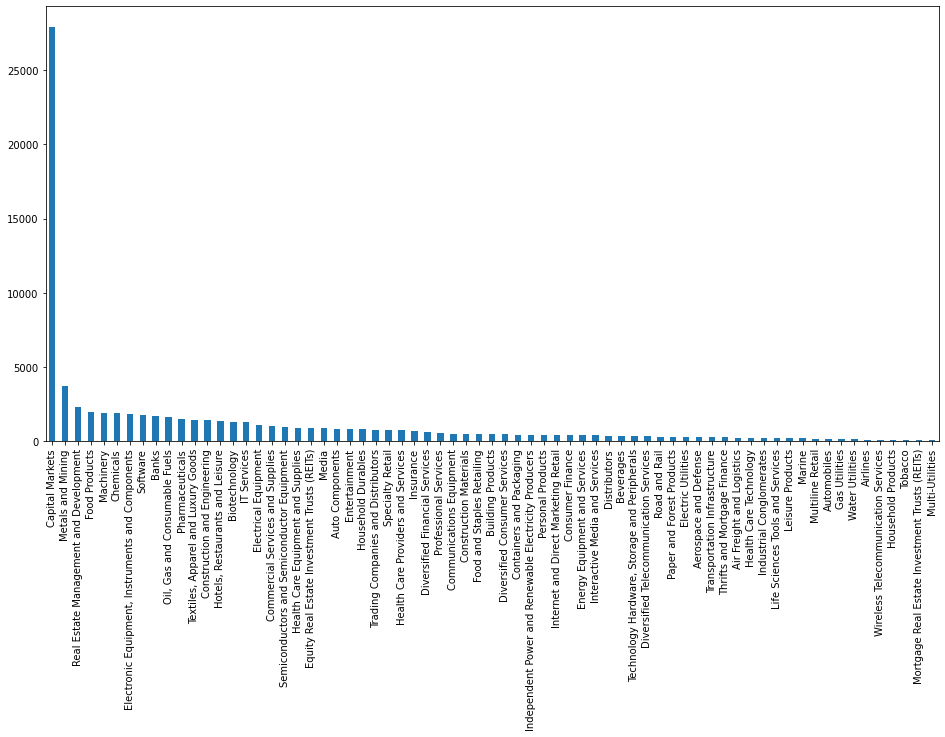

In [5]:
plt.figure(figsize=(16,8))
companies["industry"].value_counts().plot(kind='bar')

In [6]:
companies["industry"].nunique()

69

### Percebemos que tem uma desigualdade na quantidade de empresas por setor, o que poderia criar um viés nos modelos de clusterização

## Analisando o ESG

In [7]:
esg_data = pd.read_csv("esg_scores_history_rated.csv")

In [8]:
esg_data["assessment_year"] = pd.to_datetime(esg_data["assessment_year"],format="%Y")
esg_data.fillna(0,inplace=True)

In [9]:
dimensions = esg_data["parent_aspect"].unique()
dimensions

array(['Environmental Dimension', 'Governance & Economic Dimension',
       'S&P Global ESG Score', 'Social Dimension', 0], dtype=object)

In [10]:
esg_data

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
0,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Policy & Management Systems,8,43.400000
1,2013-01-01,AIR Airlines,31726,Environmental Dimension,Environmental Reporting,7,40.250000
2,2013-01-01,AIR Airlines,31726,Environmental Dimension,Operational Eco-Efficiency,11,32.400000
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
...,...,...,...,...,...,...,...
844373,2020-01-01,TSV IT services,584499446,Social Dimension,Human Rights,3,0.000000
844374,2020-01-01,TSV IT services,584499446,Social Dimension,Labor Practice Indicators,4,7.200000
844375,2020-01-01,TSV IT services,584499446,Social Dimension,Social Reporting,4,0.000000
844376,2020-01-01,TSV IT services,584499446,Social Dimension,Talent Attraction & Retention,7,25.000000


## Analisando como se comporta a distribuição dos scores por dimensão Ambiental, Governança, Social e do Global ESG 

<AxesSubplot:xlabel='parent_aspect', ylabel='score_value'>

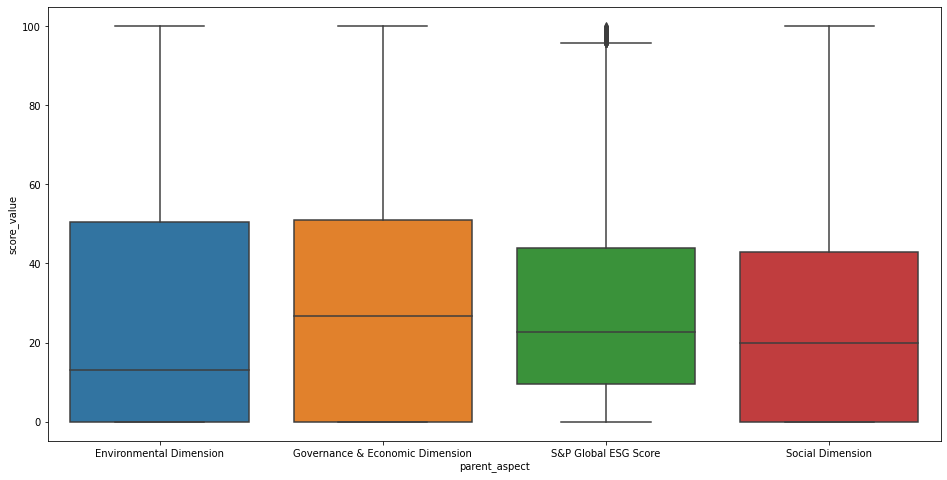

In [11]:
plt.figure(figsize=(16,8))
sns.boxplot(x="parent_aspect",y="score_value",data=esg_data[esg_data["parent_aspect"] != 0])

### Vemos que a distribuição aparenta ser similar, embora para a questão ambiental a mediana parece estar mais afastada das demais. Isso é um possível indicativo de que a questão ambiental ainda não é uma preocupação das empresas

# Vamos agora construir um modelo tal que, com base nas observações passadas, consiga predizer o score de cada uma das componentes do ESG

In [12]:
## FUNCAO QUE DADO UM DATAFRAME FAZ A MEDIA PONDERADA
def singleSum(df):
    total = 0
    denom = 0
    for i,row in df.iterrows():
        w = row["score_weight"]
        if row["score_value"] != np.nan:
            total += row["score_value"]*w
        denom += w
    return total/denom

#### Pequeno teste

In [13]:
dimensions_weights = {}
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
s = esg_data[mask].groupby("assessment_year").apply(singleSum)

In [14]:
s

assessment_year
2013-01-01    44.491053
2014-01-01    47.705467
2015-01-01    44.098280
2016-01-01    40.533114
2017-01-01    46.407925
2018-01-01    32.640737
2019-01-01    32.846734
2020-01-01    36.674379
dtype: float64

In [15]:
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


In [16]:
esg_data[esg_data["parent_aspect"].isna()]["aspect"].unique()

array([], dtype=object)

In [17]:
esg_data[mask]["score_value"].isnull().sum()

0

In [18]:
def fillSeries(df):
    idx = pd.period_range(start=df.index.min(),end=df.index.max(),freq="A")
    df = df.reindex(idx, fill_value=np.nan)
    return df.interpolate()

def makeSeries(df):
    df = df.sort_values(by="Environmental Dimension")
    s = df.set_index("Environmental Dimension")["assessment_year"]
    s = s.to_period('A')
    s = fillSeries(s)
    return s

In [19]:
## FUNCAO QUE COMPUTA O SCORE DE UMA DADA EMPRESA, NUMA DADA DIMENSÃO, E FAZ A PREVISÃO DO SCORE
def computeScore(dimension,company_id,esg_data):
    if dimension == 'S&P Global ESG Score':
        type_ = "aspect"
    else:
        type_ = "parent_aspect"
    mask = (esg_data[type_] == dimension) & (esg_data["company_id"] == company_id)
    s = esg_data[mask].groupby("assessment_year").apply(singleSum)
#     s = fillSeries(s)
    future_score = 0
    len_s = len(s)
    #O ExponentialSmoothing nao consegue fazer fit com menos de 10 pontos
    if len_s > 1:
#         model = ExponentialSmoothing(s)
        model = SimpleExpSmoothing(s)
        model.fit()
        future_score = model.predict(model.params)[0]
    elif len_s != 0:
        future_score = s[-1]
    else:
        future_score = 0
    return future_score

In [20]:
def computeScores(company_id,esg_data):
    future_scores = {}
    dims = esg_data["parent_aspect"].unique()[:4]
    for dimension in dims:
        future_scores[dimension] = computeScore(dimension,company_id,esg_data)
    return future_scores

#### Pequeno teste

In [21]:
computeScores(31726,esg_data)

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning

{'Environmental Dimension': 48.380099030658194,
 'Governance & Economic Dimension': 35.983447916430066,
 'S&P Global ESG Score': 39.51344019215944,
 'Social Dimension': 30.746574658717535}

In [22]:
mask = (esg_data["parent_aspect"] == "Governance & Economic Dimension") & (esg_data["company_id"] == 31726)
esg_data[mask]

,assessment_year,industry,company_id,parent_aspect,aspect,score_weight,score_value
3,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Antitrust Policy,3,55.750000
4,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Brand Management,4,23.000000
5,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Codes of Business Conduct,6,58.900000
6,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Corporate Governance,5,81.143270
7,2013-01-01,AIR Airlines,31726,Governance & Economic Dimension,Customer Relationship Management,4,31.540000
...,...,...,...,...,...,...,...
616705,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Policy Influence,2,43.160000
616706,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Privacy Protection,2,27.076000
616707,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Reliability,3,34.207981
616708,2020-01-01,AIR Airlines,31726,Governance & Economic Dimension,Risk & Crisis Management,4,11.890000


## Para prova de conceito, vamos fazer uma amostragem de alguns setores e efetuar os cálculos para ela

In [23]:
# sectors = companies["industry"].unique()
sectors = ['Oil, Gas and Consumable Fuels','Metals and Mining','Road and Rail','Textiles, Apparel and Luxury Goods']
# min_sector_freq = companies["industry"].value_counts().min()
min_sector_freq = 5
sample = companies[companies["industry"].isin(sectors)].groupby('industry').apply(lambda s: s.sample(min_sector_freq))[["company_id","industry","company_name"]]
sample

company_id  \
industry                                               
Metals and Mining                  10773     5579537   
                                   5060    225423067   
                                   55559   372148235   
                                   52503   631688848   
                                   33358    51613165   
Oil, Gas and Consumable Fuels      77315    28815834   
                                   56153     3102637   
                                   19710     8085841   
                                   19696    41844712   
                                   25614      878074   
Road and Rail                      27873     9559952   
                                   33017    60535786   
                                   19061   284694708   
                                   26629      875398   
                                   68930       30472   
Textiles, Apparel and Luxury Goods 18286      708276   
                                   25691      880240   
                                   28165   413044789   
                                   78414    72005078   
                                   32256     9817333   

                                                                    industry  \
industry                                                                       
Metals and Mining                  10773                   Metals and Mining   
                                   5060                    Metals and Mining   
                                   55559                   Metals and Mining   
                                   52503                   Metals and Mining   
                                   33358                   Metals and Mining   
Oil, Gas and Consumable Fuels      77315       Oil, Gas and Consumable Fuels   
                                   56153       Oil, Gas and Consumable Fuels   
                                   19710       Oil, Gas and Consumable Fuels   
                                   19696       Oil, Gas and Consumable Fuels   
                                   25614       Oil, Gas and Consumable Fuels   
Road and Rail                      27873                       Road and Rail   
                                   33017                       Road and Rail   
                                   19061                       Road and Rail   
                                   26629                       Road and Rail   
                                   68930                       Road and Rail   
Textiles, Apparel and Luxury Goods 18286  Textiles, Apparel and Luxury Goods   
                                   25691  Textiles, Apparel and Luxury Goods   
                                   28165  Textiles, Apparel and Luxury Goods   
                                   78414  Textiles, Apparel and Luxury Goods   
                                   32256  Textiles, Apparel and Luxury Goods   

                                                                            company_name  
industry                                                                                  
Metals and Mining                  10773      Ningxia Orient Tantalum Industry Co., Ltd.  
                                   5060                                  OreCorp Limited  
                                   55559                                Japan Gold Corp.  
                                   52503                           Ivor Exploration Inc.  
                                   33358  Vietnam Germany Steel Pipe Joint Stock Company  
Oil, Gas and Consumable Fuels      77315                Royalite Petroleum Company, Inc.  
                                   56153                       Montana Exploration Corp.  
                                   19710          PT Humpuss Intermoda Transportasi Tbk.  
                                   19696                          PT Bayan Resources Tbk  
                                   25614       

### Computa os escores do ESG e salva num dataframe

In [24]:
ids = sample["company_id"]
scores_df = []
for id_ in ids:
    data=computeScores(id_,esg_data)
    data["company_id"] = np.int64(id_)
    scores_df.append(data)

/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/home/felipe/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning

In [25]:
scores_df = pd.DataFrame(scores_df).fillna(0)
scores_df

,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension,company_id
0,0.000000,0.000000,0.000000,0.000000,5579537
1,0.000000,0.000000,0.000000,0.000000,225423067
2,0.000000,0.000000,0.000000,0.000000,372148235
3,0.000000,0.000000,0.000000,0.000000,631688848
4,0.000000,0.000000,0.000000,0.000000,51613165
5,0.000000,0.000000,0.000000,0.000000,28815834
6,0.000000,0.000000,0.000000,0.000000,3102637
7,0.000000,0.000000,0.000000,0.000000,8085841
8,0.000000,0.000000,0.000000,0.000000,41844712
9,0.000000,0.000000,0.000000,0.000000,878074


### Junta os scores com outros dados da empresa

In [26]:
sample = sample.merge(scores_df,left_on="company_id",right_on="company_id")
sample

,company_id,industry,company_name,Environmental Dimension,Governance & Economic Dimension,S&P Global ESG Score,Social Dimension
0,5579537,Metals and Mining,"Ningxia Orient Tantalum Industry Co., Ltd.",0.000000,0.000000,0.000000,0.000000
1,225423067,Metals and Mining,OreCorp Limited,0.000000,0.000000,0.000000,0.000000
2,372148235,Metals and Mining,Japan Gold Corp.,0.000000,0.000000,0.000000,0.000000
3,631688848,Metals and Mining,Ivor Exploration Inc.,0.000000,0.000000,0.000000,0.000000
4,51613165,Metals and Mining,Vietnam Germany Steel Pipe Joint Stock Company,0.000000,0.000000,0.000000,0.000000
5,28815834,"Oil, Gas and Consumable Fuels","Royalite Petroleum Company, Inc.",0.000000,0.000000,0.000000,0.000000
6,3102637,"Oil, Gas and Consumable Fuels",Montana Exploration Corp.,0.000000,0.000000,0.000000,0.000000
7,8085841,"Oil, Gas and Consumable Fuels",PT Humpuss Intermoda Transportasi Tbk.,0.000000,0.000000,0.000000,0.000000
8,41844712,"Oil, Gas and Consumable Fuels",PT Bayan Resources Tbk,0.000000,0.000000,0.000000,0.000000
9,878074,"Oil, Gas and Consumable Fuels",Attock Refinery Limited,0.000000,0.000000,0.000000,0.000000


### Exporta para um csv, para que possamos a continuar o protótipo em outra vertente

In [27]:
sample.to_csv("Amostra_das_empresas.csv")

<AxesSubplot:title={'center':'Valor da ação da Vale'}>

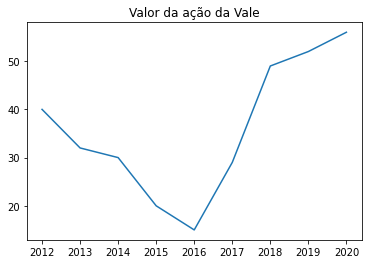

In [28]:
data = [40,32,30,20,15,29,49,52,56]
idx = np.arange(2012,2021)
s = pd.Series(data,idx)
s.plot(title="Valor da ação da Vale")